In [1]:
import numpy as np
import pandas as pd

import anndata as ad
import scanpy as sc
import squidpy as sq

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as clr
from matplotlib.pyplot import rc_context
import glasbey

import scvi

c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\numba\core\decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
c

In [2]:
sc.settings.n_jobs = 12

In [3]:
import torch
torch.set_float32_matmul_precision('high')
torch.cuda.is_available()

True

In [4]:
from lightning.pytorch import seed_everything
seed_everything(12345)

Seed set to 12345


12345

In [5]:
reference = sc.read_h5ad("../../data/scrna/seurat_objects/normal_skin.scRNA.harmony.integrated.reclustered.annotated.filtered.anndata.h5ad")


In [6]:
panel_info = pd.read_csv("../../data/merfish/BAYSOR/seurat_objects/ns-atlas.merfish_baysor.scvi_integrated.gene_data.csv",  index_col=0)

In [7]:
merfish_genes = panel_info.index.tolist()

In [8]:
reference = reference[:, merfish_genes].copy()

In [9]:
scvi.model.SCVI.setup_anndata(reference, batch_key="sample_barcode", layer="counts")
scvi_ref = scvi.model.SCVI(
    reference,
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)
scvi_ref.train(accelerator='gpu')
scvi_ref.save("../../data/scrna/scvi_reference_model", overwrite=True)

c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\scvi\data\fields\_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\scvi\model\_scvi.py:159: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the

Epoch 33/33: 100%|██████████| 33/33 [21:48<00:00, 39.70s/it, v_num=1, train_loss_step=159, train_loss_epoch=153]

`Trainer.fit` stopped: `max_epochs=33` reached.


Epoch 33/33: 100%|██████████| 33/33 [21:48<00:00, 39.66s/it, v_num=1, train_loss_step=159, train_loss_epoch=153]


In [10]:
scvi_ref = scvi.model.SCVI.load("../../data/scrna/scvi_reference_model", reference)

INFO     File ../../data/scrna/scvi_reference_model\model.pt already downloaded                                    


c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\scvi\data\fields\_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\scvi\model\_scvi.py:159: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(


In [11]:
reference.obsm["scvi"] = scvi_ref.get_latent_representation()

In [12]:
reference.obs.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pct.mito', 'pct.ribo',
       'pct.hemo', 'study_id', 'sample_barcode', 'donor_id', 'donor_sex',
       'donor_age', 'anatomic_site', 'reported.cell_type',
       'anatomic_site.detailed', 'harmony.snn_res.0.2', 'harmony.snn_res.0.4',
       'harmony.snn_res.0.5', 'harmony.snn_res.0.6', 'harmony.snn_res.0.8',
       'harmony.snn_res.1', 'harmony.snn_res.1.2', 'harmony.snn_res.1.5',
       'harmony.snn_res.2', 'harmony.snn_res.2.5', 'seurat_clusters',
       'cell_barcode', 'cell_category', 'cell_type', 'cell_type.broad.res_0.2',
       'cell_type.reclustered', 'cell_type.detailed',
       'cell_type.detailed.reclustered.cca.predicted_id', 'cell_type.broad',
       'cell_type.broad.res_1', 'cell_type.detailed.nonharmonized',
       'cell_type.harmonized', '_scvi_batch', '_scvi_labels'],
      dtype='object')

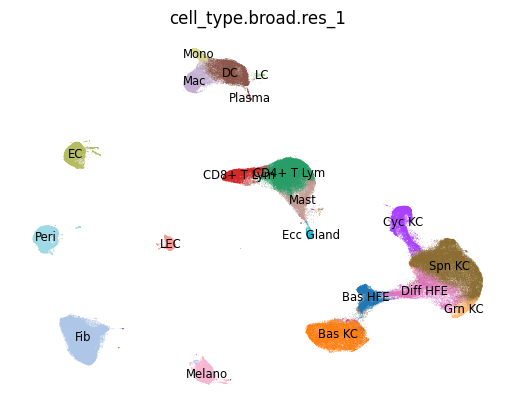

In [13]:
sc.pl.embedding(reference, basis='umap', color='cell_type.broad.res_1', legend_loc='on data', frameon=False, legend_fontweight='normal', legend_fontsize='small')

In [14]:
SCANVI_LABELS_KEY = "labels_scanvi"
reference.obs[SCANVI_LABELS_KEY] = reference.obs['cell_type.broad.res_1'].values

In [15]:
scanvi_ref = scvi.model.SCANVI.from_scvi_model(scvi_ref, labels_key=SCANVI_LABELS_KEY, unlabeled_category="UNKNOWN")
scanvi_ref.train(accelerator='gpu')
scanvi_ref.save("../../data/scrna/scanvi_reference_model", overwrite=True)

c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\scvi\data\fields\_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\scvi\model\_scanvi.py:139: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(self.adata_manager, n_batch)


INFO     Training for 10 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 10/10: 100%|██████████| 10/10 [14:39<00:00, 88.25s/it, v_num=1, train_loss_step=143, train_loss_epoch=161]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [14:39<00:00, 87.96s/it, v_num=1, train_loss_step=143, train_loss_epoch=161]


In [16]:
reference.obsm["scanvi"] = scanvi_ref.get_latent_representation()

In [17]:
reference.write_h5ad("../../data/scrna/ns-atlas.scrna.scvi_reference.anndata.h5ad")